The purpose of this project is to use AOI images to train deep learning models to identify product surface defeats, including 6 categories(normal category + 5 defeat categories)
本議題所提供之影像資料，包含 6 個類別（正常類別 + 5 種瑕疵類別）。

下載資料 zip 檔案包含：

train_images.zip：訓練所需的影像資料（JPEG格式），共計 5,056 張。
train.csv：包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（0 表示 normal，1 表示 void，2 表示 horizontal defect，3 表示 vertical defect，4 表示 edge defect，5 表示 particle）。
test_images.zip：測試所需的影像資料（JPEG格式），共計 19,278 張。
test.csv：包含 1 個欄位，ID 。
ID：影像的檔名。
upload_sample.csv:上傳範例。包含 2 個欄位，ID 和 Label。
ID：影像的檔名。
Label：瑕疵分類類別（其值只能是下列其中之一：0、1、2、3、4、5）。

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import sys
import pandas as pd
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
print (tf.__version__)

2.9.1


Download dataset by https://aidea-web.tw/topic/285ef3be-44eb-43dd-85cc-f0388bf85ea4

In [2]:
dirname  = './'
NUM_CLASSES = 6
# 影像類別名稱
class_names = ['normal', 'void', 'horizontal defect', 'vertical defect', 'edge defect', 'particle']
# 模型輸出儲存的檔案
WEIGHTS_FINAL = (dirname+'model-resnet50-final.h5')

In [3]:
train_label = pd.read_csv('train.csv')
test_label = pd.read_csv('test.csv')
train_label_ID = train_label['ID'].values
test_label_ID = test_label['ID'].values
train_label_Label = train_label['Label'].values

In [4]:
print (test_label)

                   ID  Label
0      test_00000.png    NaN
1      test_00001.png    NaN
2      test_00002.png    NaN
3      test_00003.png    NaN
4      test_00004.png    NaN
...               ...    ...
10137  test_10137.png    NaN
10138  test_10138.png    NaN
10139  test_10139.png    NaN
10140  test_10140.png    NaN
10141  test_10141.png    NaN

[10142 rows x 2 columns]


In [5]:
class0 = []
class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for n, element in enumerate(train_label_ID):
    if train_label_Label[n] == 0 :
        class0.append(element)
    elif train_label_Label[n] == 1 :
        class1.append(element)
    elif train_label_Label[n] == 2 :
        class2.append(element)
    elif train_label_Label[n] == 3 :
        class3.append(element)
    elif train_label_Label[n] == 4 :
        class4.append(element)
    elif train_label_Label[n] == 5 :
        class5.append(element)
    
print ("Class0 Count of samples = {}".format(len(class0)))
print ("Class1 Count of samples = {}".format(len(class1)))
print ("Class2 Count of samples = {}".format(len(class2)))
print ("Class3 Count of samples = {}".format(len(class3)))
print ("Class4 Count of samples = {}".format(len(class4)))
print ("Class5 Count of samples = {}".format(len(class5)))
print ("Totel training samples = {}".format(len(train_label_Label)))

Class0 Count of samples = 674
Class1 Count of samples = 492
Class2 Count of samples = 100
Class3 Count of samples = 378
Class4 Count of samples = 240
Class5 Count of samples = 644
Totel training samples = 2528


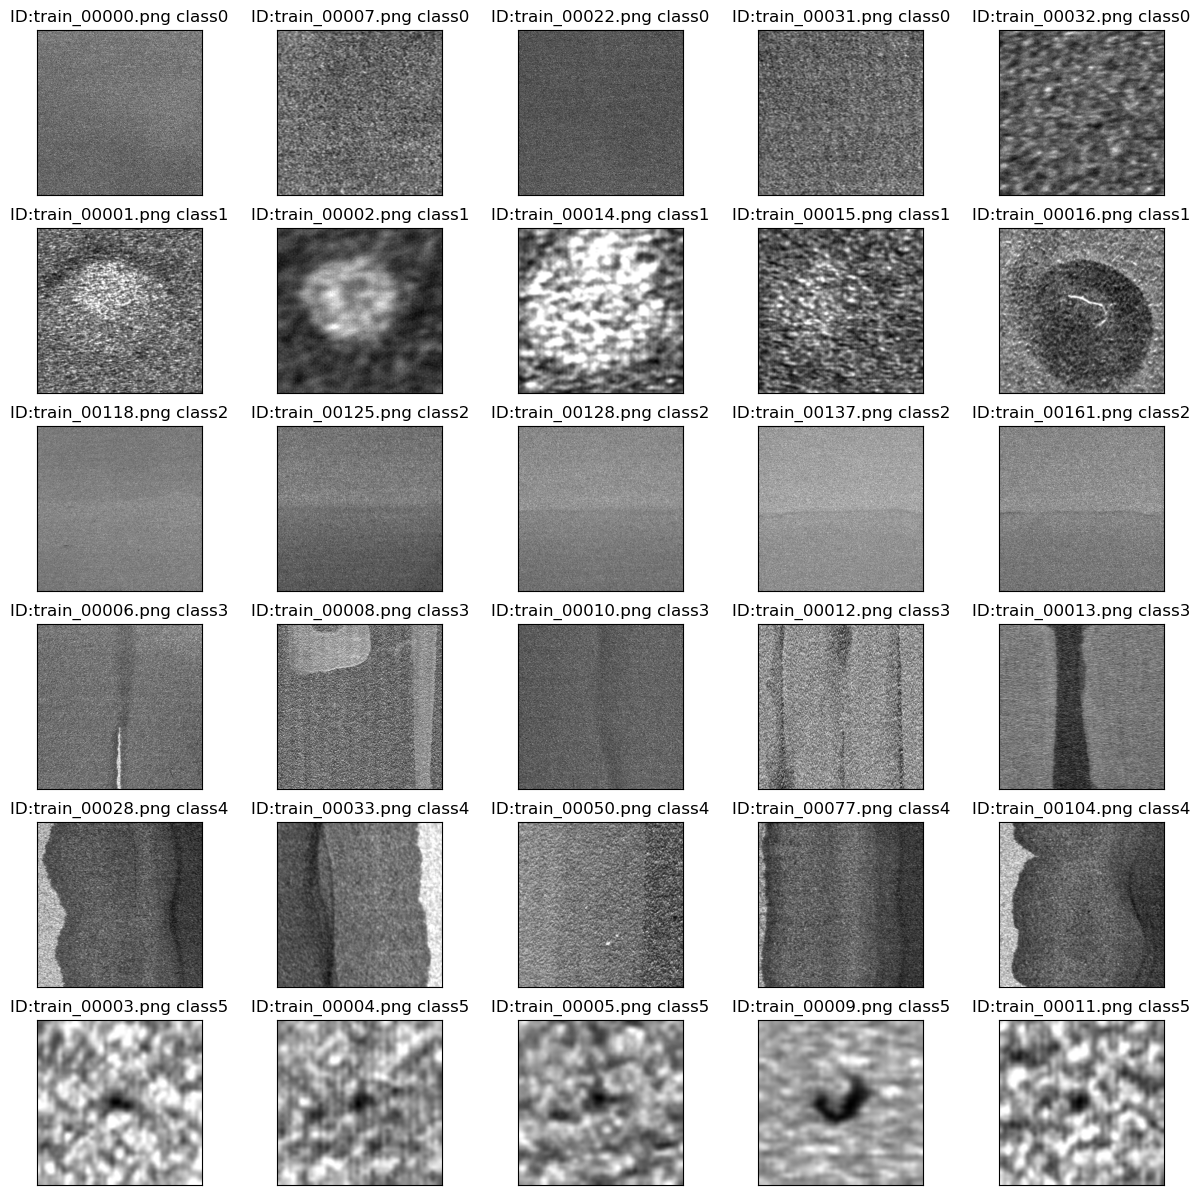

In [6]:
n = 5 #samples
plt.figure(figsize=(15,15))
for i in range(n):
    #
    ax = plt.subplot(6, n, i +1)
    name = class0[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class0')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +6)
    name = class1[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class1')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +11)
    name = class2[i]   
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class2')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +16)
    name = class3[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class3')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +21)
    name = class4[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class4')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #
    ax = plt.subplot(6, n, i +26)
    name = class5[i]
    with Image.open(f'train_images/{name}') as img :
        plt.imshow(img,cmap='gray')
        plt.title('ID:'+name+' class5')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Generate a Dataset

In [8]:
# Option1 -> the return to array dataset

def readfile(path, labels):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 224, 224, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = image.load_img(path+"/"+file, target_size=(224, 224))
        x[i, :, :] = img
        if labels:
            y[i] = int(train_label_Label[i])
    if labels:
        return x, y
    else:
        return x
workspace_dir = 'train_images'
print("Reading data")

train_x, train_y = readfile('train_images', True)
print("Size of training data = {}".format(len(train_x)))

test_x = readfile('test_images', False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 2528
Size of Testing data = 10142


Prepare tf.data.Dataset objects

In [15]:
image_size = 224
batch_size =32
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_x))


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical")
    ])



def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=False)
test_ds = prepare(test_ds, shuffle=False, augment=False)

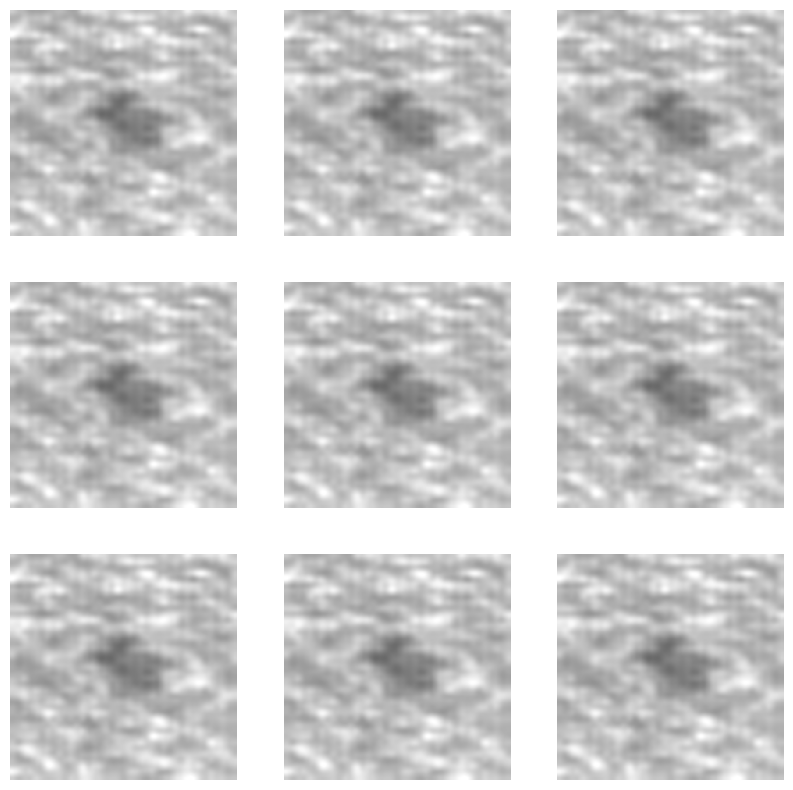

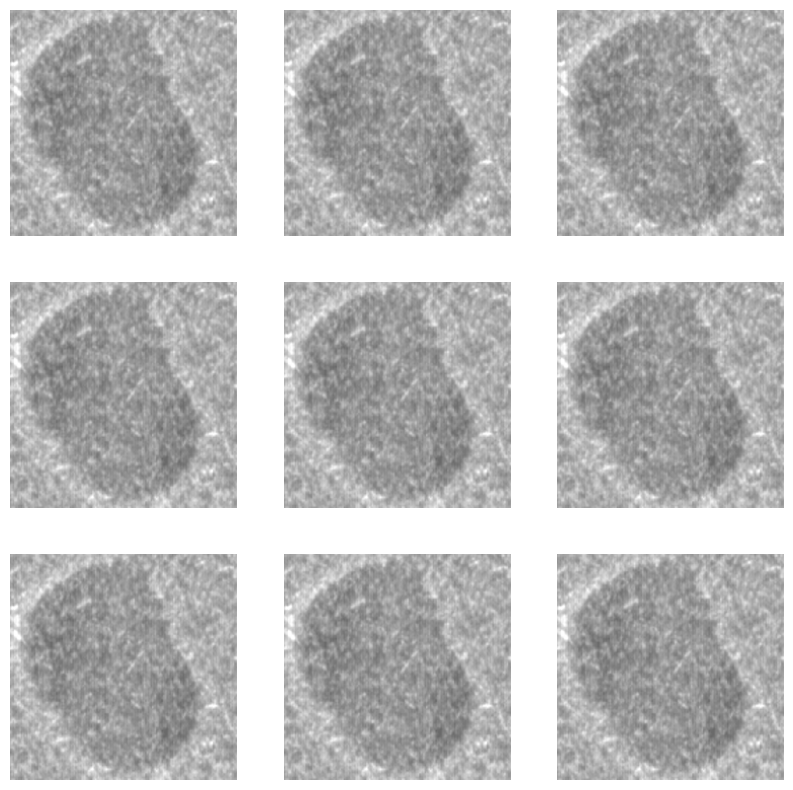

In [16]:
for image, _ in train_ds.take(2):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [28]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size,image_size,3))
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(image_size, image_size)
    ])
#build model
net = tf.keras.Sequential([tf.keras.Input(shape=(image_size, image_size, 3)),
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  Dense(512, activation='relu'),
  Dense(NUM_CLASSES, activation='softmax')
  ])
net.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                      

In [30]:
base_learning_rate = 0.0001
initial_epochs = 20
net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])
history = net.fit(
    train_ds,
    epochs=initial_epochs
    )

Epoch 1/20
79/79 [==============================] - 5s 39ms/step - loss: 0.7902 - accuracy: 0.7508
Epoch 2/20
79/79 [==============================] - 3s 39ms/step - loss: 0.2824 - accuracy: 0.9150
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 0.1907 - accuracy: 0.9486
Epoch 4/20
79/79 [==============================] - 3s 39ms/step - loss: 0.1511 - accuracy: 0.9593
Epoch 5/20
79/79 [==============================] - 3s 38ms/step - loss: 0.1296 - accuracy: 0.9644
Epoch 6/20
79/79 [==============================] - 3s 40ms/step - loss: 0.1047 - accuracy: 0.9707
Epoch 7/20
79/79 [==============================] - 3s 39ms/step - loss: 0.1005 - accuracy: 0.9691
Epoch 8/20
79/79 [==============================] - 3s 40ms/step - loss: 0.0948 - accuracy: 0.9727
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0888 - accuracy: 0.9743
Epoch 10/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0830 - accuracy: 0.9747
Epoch 11/

Fine tuning

In [31]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
print("Number of layers in the base model: ", len(base_model.trainable_variables))


Number of layers in the base model:  190
Number of layers in the base model:  82


In [32]:
net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])
net.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                      

In [33]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = net.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         )

Epoch 20/50
79/79 [==============================] - 7s 58ms/step - loss: 1.2471 - accuracy: 0.7512
Epoch 21/50
79/79 [==============================] - 4s 56ms/step - loss: 0.2528 - accuracy: 0.9189
Epoch 22/50
79/79 [==============================] - 4s 56ms/step - loss: 0.1503 - accuracy: 0.9486
Epoch 23/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0945 - accuracy: 0.9715
Epoch 24/50
79/79 [==============================] - 4s 56ms/step - loss: 0.0763 - accuracy: 0.9747
Epoch 25/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0596 - accuracy: 0.9806
Epoch 26/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0473 - accuracy: 0.9854
Epoch 27/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0357 - accuracy: 0.9897
Epoch 28/50
79/79 [==============================] - 4s 55ms/step - loss: 0.0419 - accuracy: 0.9866
Epoch 29/50
79/79 [==============================] - 4s 56ms/step - loss: 0.0353 - accuracy: 0.9905


In [34]:
# 儲存訓練好的模型
net.save(WEIGHTS_FINAL)

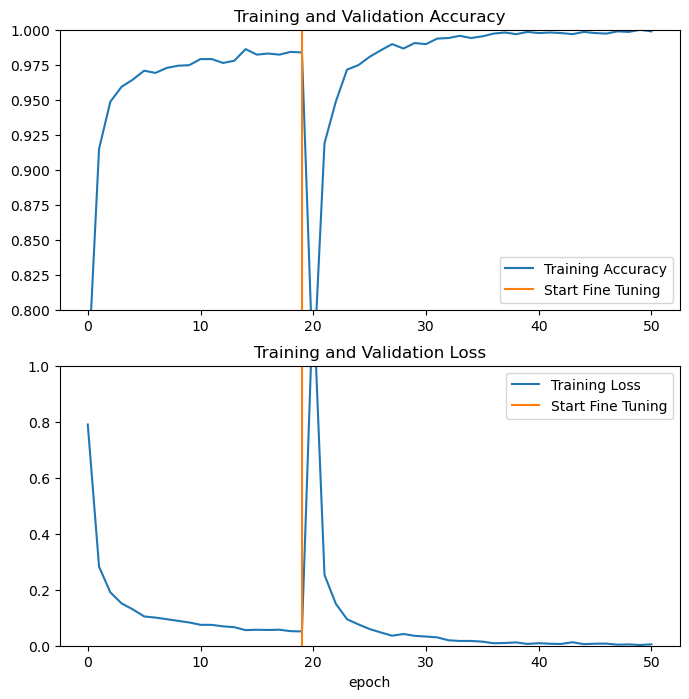

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc += history_fine.history['accuracy']
#val_acc += history_fine.history['val_accuracy']
loss = history.history['loss']
loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
validation_loss,validation_acc = net.evaluate(train_ds)
print (validation_loss,validation_acc)

79/79 [==============================] - 3s 28ms/step - loss: 4.6658e-04 - accuracy: 0.9996
0.0004665758169721812 0.9996044039726257


In [37]:
predictions = net.predict(test_ds)

317/317 [==============================] - 9s 26ms/step


In [38]:
print (predictions.shape)
np.argmax(predictions[0])

(10142, 6)


1

In [39]:
#將結果寫入 CSV 檔
with open('test_out.csv', 'w') as outfile:
    outfile.write('ID,Label\n')
    for i, y in enumerate(predictions):
        name = test_label_ID[i]
        pred = np.argmax(y)
        print (name,pred)
        outfile.write('{},{}\n'.format(name,pred))

test_00000.png 1
test_00001.png 2
test_00002.png 5
test_00003.png 0
test_00004.png 2
test_00005.png 5
test_00006.png 5
test_00007.png 5
test_00008.png 0
test_00009.png 2
test_00010.png 3
test_00011.png 0
test_00012.png 0
test_00013.png 1
test_00014.png 1
test_00015.png 0
test_00016.png 0
test_00017.png 5
test_00018.png 0
test_00019.png 0
test_00020.png 4
test_00021.png 1
test_00022.png 4
test_00023.png 5
test_00024.png 0
test_00025.png 0
test_00026.png 5
test_00027.png 0
test_00028.png 5
test_00029.png 5
test_00030.png 1
test_00031.png 5
test_00032.png 4
test_00033.png 1
test_00034.png 2
test_00035.png 4
test_00036.png 1
test_00037.png 3
test_00038.png 0
test_00039.png 1
test_00040.png 2
test_00041.png 5
test_00042.png 4
test_00043.png 1
test_00044.png 5
test_00045.png 5
test_00046.png 0
test_00047.png 4
test_00048.png 4
test_00049.png 3
test_00050.png 5
test_00051.png 5
test_00052.png 5
test_00053.png 4
test_00054.png 0
test_00055.png 0
test_00056.png 0
test_00057.png 0
test_00058.png